# 01. Activity Driven Networks

In this notebook, we will create a simple python code that generates a temporal network considering the activity driven framework.

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import networkx as nx

### 1. Sample Activities

As a first exercise, we define a function that samples the activity from a power law distribution using the inversion method:


$$F(a) \sim a^{-\alpha}$$

(https://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html)

In [3]:
def sample_activity(eps, alpha):
    """
    This function samples the activity from a distribution F(a) ~ a^-alpha
    Parameters
    ----------
        @param eps: the minimum activity value
        @param alpha: the exponent of the power law distribution
    Returns
    -------
        @return: the sampled activity
    """
    y = random.random()
    a = (y + (1 - y) * (eps ** (1 - alpha))) ** (1 / (1 - alpha))
    return a

We test the function sampling $10^6$ activities considering a distribution with $\alpha=2.1$ and the minimum activity value $\epsilon=10^{-3}$ (to avoid divergence near the origin):

Text(0.5, 0, 'activity')

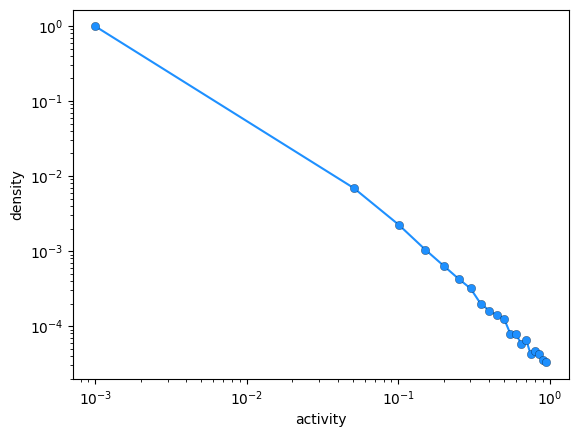

In [5]:
# sample 10**6 activities and plot their distribution
activities = [sample_activity(eps=10**(-3), alpha=2.1) for i in range(1000000)]

counts, bins = np.histogram(activities, bins=20)
counts = counts / np.sum(counts)  # normalize

#fig, ax = plt.subplots(dpi=300)
plt.plot(bins[:-1], counts, color="dodgerblue", marker="o", markeredgewidth=0.2, markeredgecolor='black')
plt.xscale("log")
plt.yscale("log")

plt.ylabel("density")
plt.xlabel("activity")


### 2. Simulate Network (Random Partner Selection)

As a second exercise, we define a functions that generates the temporal network using the activity driven framework with random partner selection.


In [6]:
def sample_neighbours(index, m, N):
    """
    This function samples the neighbours
    Parameters
    ----------
        @param index: source node index
        @param m: number of neighbours to sample
        @param N: total number of nodes
    Returns
    -------
        @return: the sampled neighbours
    """
    return np.random.choice([idx for idx in range(N) if idx != index], size=m)


def get_adn_network(T, N, eps, alpha, m):
    """
    This function generates a temporal network using the activity
    driven framework
    Parameters
    ----------
        @param T: number of timesteps
        @param N: total number of nodes
        @param eps: the minimum activity value
        @param alpha: the exponent of the power law distribution
        @param m: number of neighbours to sample
    Returns
    -------
        @return: the total aggragated network, the timestep networks, 
                 and the time aggregated networks at different timesteps
    """
    # initialize activities
    activities = np.array([sample_activity(eps=eps, alpha=alpha) for i in range(N)])

    G_tot = nx.Graph()
    Gs, Gs_tot = [], []

    for t in range(T):
        Gs.append(nx.Graph())
        for i in range(len(activities)):
            # check if node is active
            if np.random.random() < activities[i]:
                # sample m random neighbours
                rnd_neigh = sample_neighbours(i, m, N)
                for n in rnd_neigh:
                    G_tot.add_edge(i, n)
                    Gs[-1].add_edge(i, n)
        Gs_tot.append(G_tot.copy())
    return G_tot, Gs, Gs_tot


def plot_network(G, k, ax=None):
    """
    This function plots a given network
    Parameters
    ----------
        @param G: the network to plot (nx.Graph object)
        @param k: plotting parameter
        @param ax: axes object, defaults to None
    """
    if ax == None:
        fig, ax = plt.subplots(dpi=300)

    d = dict(G.degree)
    nx.draw(G, 
            nodelist=d.keys(), 
            pos=nx.spring_layout(G, k=k),
            width=0.1, 
            node_size=[v for v in d.values()], 
            node_color=[v for v in d.values()], 
            cmap=sns.color_palette("crest", as_cmap=True), 
            ax=ax)

We test the functions generating a network with $5,000$ nodes over 20 timesteps and plotting the time-varying network at different timesteps:

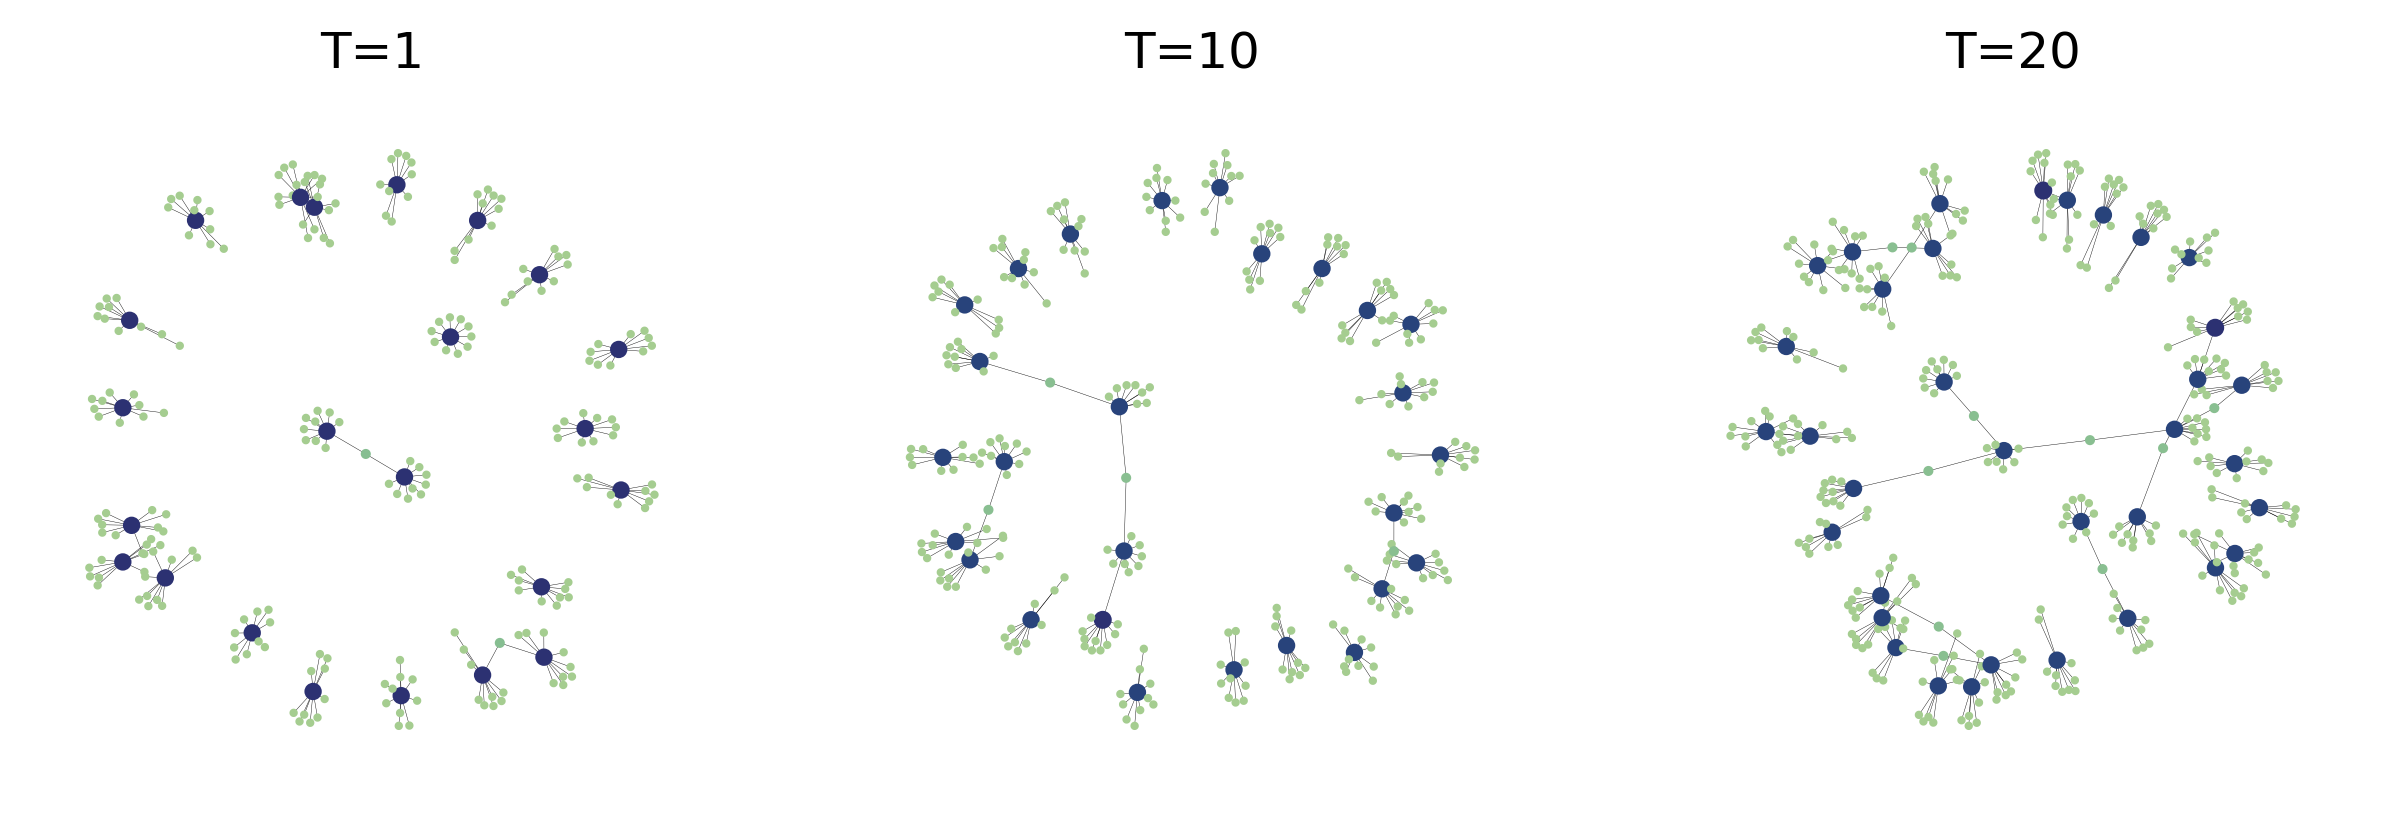

In [7]:
G_tot, Gs, Gs_tot = get_adn_network(T=20, N=5000, eps=10**-3, alpha=2.1, m=10)

fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(10,3))
plot_network(G=Gs[0], ax=axes[0], k=0.1)
plot_network(G=Gs[9], ax=axes[1], k=0.1)
plot_network(G=Gs[19], ax=axes[2], k=0.1)

axes[0].set_title("T=1")
axes[1].set_title("T=10")
axes[2].set_title("T=20")

plt.savefig("./img/adn_nets.pdf", bbox_inches="tight")

Additionally, we also plot the aggregated network at different time steps:

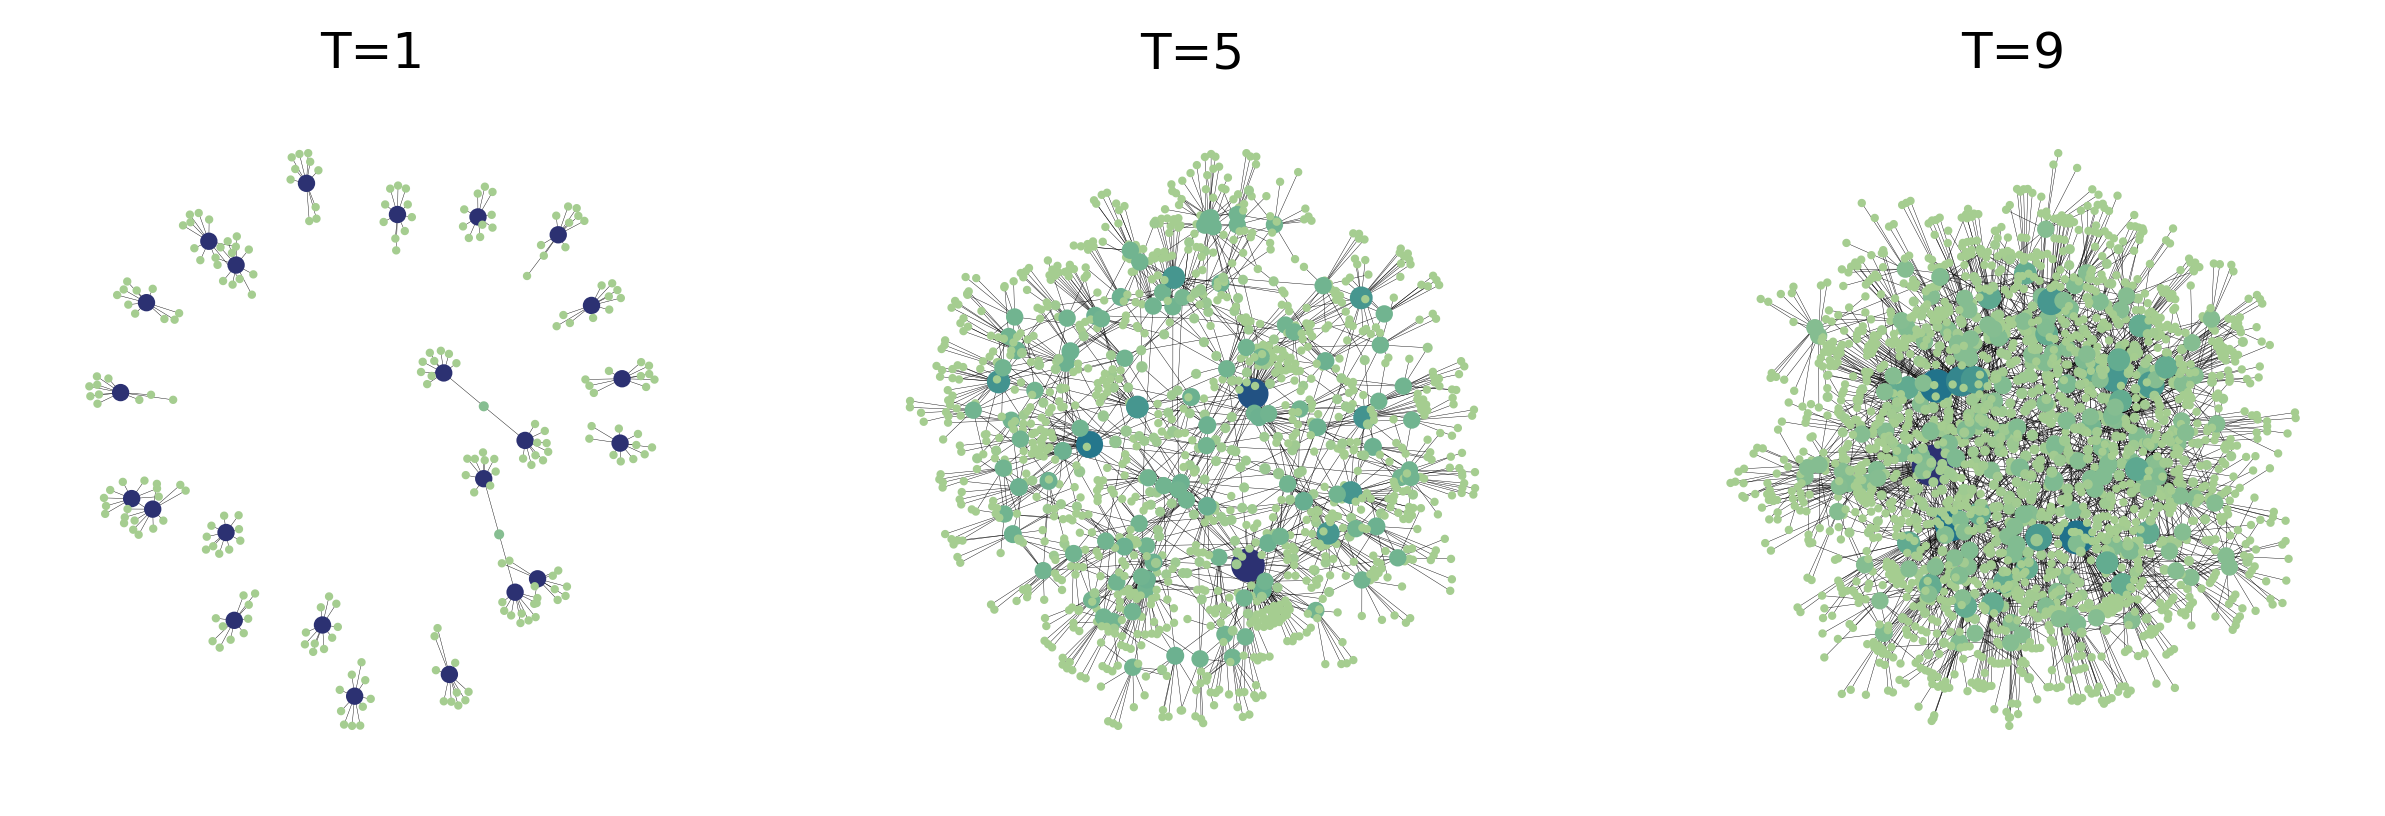

In [8]:
fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(10,3))
plot_network(G=Gs_tot[0], ax=axes[0], k=0.1)
plot_network(G=Gs_tot[4], ax=axes[1], k=0.1)
plot_network(G=Gs_tot[8], ax=axes[2], k=0.1)

axes[0].set_title("T=1")
axes[1].set_title("T=5")
axes[2].set_title("T=9")

plt.savefig("./img/adn_nets_aggregated.pdf", bbox_inches="tight")

### 3. Simulate Network (Communities)

As a third exercise, we define a functions that generates the temporal network using the activity driven framework with communities.

For simplicity, we will assume equal communities with fixed size.

In [9]:
def sample_neighbours_community(index, m, nodes_list):
    """
    This function samples the neighbours in the case of communities
    Parameters
    ----------
        @param index: source node index
        @param m: number of neighbours to sample
        @param nodes_list: list of nodes in a community
    Returns
    -------
        @return: the sampled neighbours
    """
    return np.random.choice([idx for idx in nodes_list if idx != index], size=m)


def get_adn_network_community(T, N, eps, alpha, m, eta, community_size=10):
    """
    This function generates a temporal network using the activity
    driven framework with communities
    Parameters
    ----------
        @param T: number of timesteps
        @param N: total number of nodes
        @param eps: the minimum activity value
        @param alpha: the exponent of the power law distribution
        @param m: number of neighbours to sample
        @param eta: network modularity parameter
        @param community_size: size of each community
    Returns
    -------
        @return: the total aggragated network, the timestep networks, 
                 and the time aggregated networks at different timesteps
    """
    # initialize activities
    activities = np.array([sample_activity(eps=eps, alpha=alpha) for i in range(N)])

    # initialize communities 
    communities = {i: [] for i in range(int(N / community_size))}
    nodes_community_match = []
    for i in range(N):
        comm = np.random.choice(list(communities.keys()))
        communities[comm].append(i)
        nodes_community_match.append(comm)

    G_tot = nx.Graph()
    Gs, Gs_tot = [], []

    for t in range(T):
        Gs.append(nx.Graph())
        for i in range(len(activities)):
            # check if node is active
            if np.random.random() < activities[i]:

                # decide if contacts are within or outside the community
                if random.random() < eta: 
                    # sample neighbour in community
                    rnd_neigh = sample_neighbours_community(i, m, communities[nodes_community_match[i]])

                else: 
                    # sample neighbour outside community
                    rnd_comm = np.random.choice([c for c in list(communities.keys()) if c != nodes_community_match[i]])
                    rnd_neigh = sample_neighbours_community(i, m, communities[rnd_comm])
 
                for n in rnd_neigh:
                    G_tot.add_edge(i, n)
                    Gs[-1].add_edge(i, n)
        Gs_tot.append(G_tot.copy())
    return G_tot, Gs, Gs_tot

In [11]:
# graph with three disconnected components
G_tot_comm, Gs_comm, Gs_tot_comm = get_adn_network_community(T=20, N=6000, eps=10**-3, alpha=2.1, m=10, eta=0.6, community_size=2000)

# check its connected components
[len(c) for c in sorted(nx.connected_components(Gs_tot_comm[-1]), key=len, reverse=True)]

[4169]